# Постановка задачи
### Проблема:

Представьте, что Вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### Цель проекта: построить модель на основе алгоритмов машинного обучения, которая предсказывает рейтинг отеля.

### Задачи проекта:

* ознакомиться с входными данными
* изучить пример машинного обучения
* выполнить подготовку данных, которые будут использованы для обучения модели
* проверить эффективность предлагаемой модели, используя метрику MAPE
* принять участие в соревнованиях на площадке kaggle.com

# Знакомимся с данными
Первоначальная версия [датасета](https://drive.google.com/file/d/1Qj0iYEbD64eVAaaBylJeIi3qvMzxf2C_/view?usp=sharing) содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

# Импорт библиотек

In [2]:
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import category_encoders as ce
from sklearn import preprocessing

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anast\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Обзор данных

In [11]:
# Знакомимся с данными.
hotels = pd.read_csv('data\hotels.csv')


In [12]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [13]:
hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


# **Преобразование данных**

### **Первичная обработка пропусков в датафрейме и переформатирование дат в datetime**

In [14]:
# Признаки широты и долготы в датасете имеют пропущенные значения. Заменим их пока на 0:
hotels = hotels.fillna(0)
# Приведём столбец с датой к формату datetime:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

### **Преобразование 'reviewer_nationality'**

In [15]:
hotels['reviewer_nationality'].value_counts()

 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
                               ...  
 Cook Islands                      1
 Guinea                            1
 Comoros                           1
 Anguilla                          1
 Grenada                           1
Name: reviewer_nationality, Length: 225, dtype: int64

In [16]:
# Кодируем бинарным кодированием.
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

### **Работа с признаком 'hotel_address'**

In [17]:
# Выделяем признак города из адреса отеля
hotels['city'] = hotels['hotel_address'].str.split()
hotels['city'] = hotels['city'].apply(lambda x: x[-2])
hotels['city'] = hotels['city'].apply(lambda x: 'London' if x == 'United' else x)

# Кодируем значения методом OneHotEncoding:
encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['city'])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.head(3)

c:\Users\anast\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,city,city_London,city_Paris,city_Amsterdam,city_Milan,city_Vienna,city_Barcelona
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,0,1,London,1,0,0,0,0,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,0,1,London,1,0,0,0,0,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,0,1,0,Paris,0,1,0,0,0,0


### **Работа с признаком 'tags'**

**Формируем признак количества ночей**

In [18]:
# сформируем новый признак с количеством проведённых ночей в отелях с помощью регулярного выражения:
regex = '\d night'
hotels['cnt_nights'] = hotels['tags'].str.findall(regex).str.get(0)
# 146 пропущенных значений заменим на 0
hotels['cnt_nights'] = hotels['cnt_nights'].fillna(0) 
# Преобразуем строки в числовые значения.
hotels['cnt_nights'] = hotels['cnt_nights'].apply(lambda x: int(str(x).split()[0])) 

hotels['cnt_nights'].head()

0    2
1    1
2    3
3    1
4    6
Name: cnt_nights, dtype: int64

In [19]:
def update_tags(st):
    '''
    Функция преобразования признака 'tags' в более удобный строковый вид
    '''
    st = st.replace('[', '')
    st = st.replace(']', '')
    st = st.replace("'", '')
    st = st.replace('[', '')
    return st

hotels['tags'] = hotels['tags'].apply(update_tags)
hotels['tags'][0]

' Leisure trip ,  Couple ,  Studio Suite ,  Stayed 2 nights ,  Submitted from a mobile device '

In [20]:
# Создадим и преобразуем признак категории путешественников:

hotels['travelers'] = hotels['tags'].str.replace('.Leisure.trip..', '', regex=True)
hotels['travelers'] = hotels['travelers'].str.replace('.Business.trip..', '', regex=True)
hotels['travelers'] = hotels['travelers'].str.split(',')
hotels['travelers'] = hotels['travelers'].apply(lambda x: x[0])
hotels['travelers'] = hotels['travelers'].str.lstrip(' ')
hotels['travelers'] = hotels['travelers'].str.rstrip(' ')
hotels['travelers'].value_counts()

Couple                        188672
Solo traveler                  81072
Group                          48982
Family with young children     45671
Family with older children     19731
Travelers with friends          1630
With a pet                      1045
Name: travelers, dtype: int64

In [21]:
# Кодировка признака 'travelers'. Для 7 категориальных значений подойдёт OneHotEncoder:

encoder = ce.OneHotEncoder(cols=['travelers'], use_cat_names=True)
type_bin = encoder.fit_transform(hotels['travelers'])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.head(2)

c:\Users\anast\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,city_Barcelona,cnt_nights,travelers,travelers_Couple,travelers_Solo traveler,travelers_Family with young children,travelers_Group,travelers_Family with older children,travelers_Travelers with friends,travelers_With a pet
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,2,Couple,1,0,0,0,0,0,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,1,Couple,1,0,0,0,0,0,0


In [22]:
# Создадим признак комнаты в отеле

hotels['rooms'] = hotels['tags'].str.replace('.Leisure.trip..', '', regex=True)
hotels['rooms'] = hotels['rooms'].str.replace('.Business.trip..', '', regex=True)
hotels['rooms'] = hotels['rooms'].str.replace('^.*Solo traveler.,', '', regex=True)
hotels['rooms'] = hotels['rooms'].str.replace('^.*Family with older children.,', '', regex=True)
hotels['rooms'] = hotels['rooms'].str.replace('^.*Couple.,', '', regex=True)
hotels['rooms'] = hotels['rooms'].str.replace('^.*Group.,', '', regex=True)
hotels['rooms'] = hotels['rooms'].str.replace('^.*Travelers with friends.,', '', regex=True)
hotels['rooms'] = hotels['rooms'].str.replace('^.*Family with young children.,', '', regex=True)
hotels['rooms'] = hotels['rooms'].str.replace('^.*With a pet.,', '', regex=True)
hotels['rooms'] = hotels['rooms'].str.split(',')
hotels['rooms'] = hotels['rooms'].apply(lambda x: x[0])
hotels['rooms'] = hotels['rooms'].str.lstrip(' ')
hotels['rooms'] = hotels['rooms'].str.rstrip(' ')

hotels['rooms'].value_counts()

Double Room                                                26386
Standard Double Room                                       24151
Superior Double Room                                       23550
Deluxe Double Room                                         18623
Double or Twin Room                                        16824
                                                           ...  
Junior Suite with Hydromassage Shower                          1
Junior Suite Saint Honor                                       1
Suite with Garden View and Parking                             1
Superior One Bedroom Suite with Executive Lounge Access        1
Executive Double Room Non Smoking                              1
Name: rooms, Length: 2334, dtype: int64

In [23]:
# Признак 'rooms' оказался с очень большим количеством уникальных значений.
# Кодируем бинарным кодированием.

bin_encoder = ce.BinaryEncoder(cols=['rooms']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['rooms'])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 54 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

**Создаём признак написания отзыва с мобильного**

In [24]:
# Submitted from a mobile device: да(1) или нет(0)

hotels['Submitted from a mobile device'] = hotels['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)
hotels['Submitted from a mobile device']

0         1
1         0
2         1
3         0
4         0
         ..
386798    1
386799    1
386800    0
386801    0
386802    0
Name: Submitted from a mobile device, Length: 386803, dtype: int64

**Создадим признак типа поездки trip_type,где:**
* 1 - поездка для отдыха
* 2 - деловая поездка
* 0 - не указано

In [25]:
# Создадим признак типа поездки trip_type:
def trip_type(x):
    if x.split(',')[0] == ' Leisure trip ':
        return 1  # поездка для отдыха
    elif x.split(',')[0] == ' Business trip ':
        return 2   # деловая поездка
    else:
        return 0    # другое
    
hotels['trip_type'] = hotels['tags'].apply(trip_type)

In [26]:
hotels['trip_type'].value_counts()

1    312768
2     61846
0     12189
Name: trip_type, dtype: int64

### **Кодируем названия отелей**

In [27]:
hotels['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
                                                     ... 
Ibis Styles Milano Palmanova                            7
Renaissance Paris Republique Hotel Spa                  7
Hotel Wagner                                            6
Hotel Gallitzinberg                                     6
Mercure Paris Porte d Orleans                           5
Name: hotel_name, Length: 1492, dtype: int64

In [28]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # Используем бинарное кодирование
type_bin = bin_encoder.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

### **Работа с признаком 'review_date'**

In [29]:
# Извлекаем признак месяца из даты
hotels['review_season'] = hotels['review_date'].dt.month

def seasons(i):
    if i in [1, 2, 12]:
        return 1
    elif i in [3, 4, 5]:
        return 2
    elif i in [6, 7, 8]:
        return 3
    else:
        return 4
    
hotels['review_season'] = hotels['review_season'].apply(seasons)
hotels['review_season']

0         1
1         1
2         4
3         4
4         2
         ..
386798    2
386799    1
386800    1
386801    2
386802    3
Name: review_season, Length: 386803, dtype: int64

### **Преобразование days_since_review**

In [30]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

### **Обработка положительных и отрицательных отзывов**

Создадим новые признаки с нормализованной оценкой позитива и негатива в отзывах с помощью анализатора **SentimentIntensityAnalyzer**.

Разобрался с ним с помощью [этой статьи](https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664)

In [31]:
%%time

sid = SentimentIntensityAnalyzer()

# Создаём два новых признака. Анализатор принимает строку и возвращает словарь оценок в каждой из четырех категорий: 
# отриц. (neg) 
# нейтр.(neu) 
# положит.(pos) 
# compound (рассчитывается путем нормализации оценок, приведенных выше)

hotels['positive'] = hotels.positive_review.apply(lambda x: sid.polarity_scores(x))
hotels['negative'] = hotels.negative_review.apply(lambda x: sid.polarity_scores(x))   
# Выделяем оценку из словаря по ключу:
hotels['positive'] = hotels['positive'].apply(lambda x: x['compound'])
hotels['negative'] = hotels['negative'].apply(lambda x: x['compound'])


print('Диапазон значений негатив-позитив:  ', hotels['negative'].min(),'...', hotels['positive'].max())

Диапазон значений негатив-позитив:   -0.9981 ... 0.9993
CPU times: total: 3min 44s
Wall time: 4min 30s


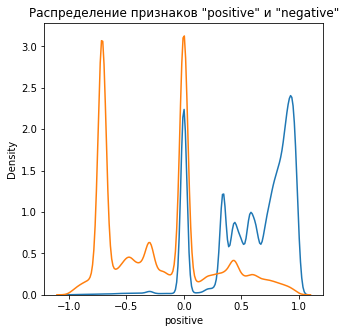

In [32]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
ax1.set_title('Распределение признаков "positive" и "negative"')
sns.kdeplot(hotels['positive'], ax=ax1)
sns.kdeplot(hotels['negative'], ax=ax1);



# **Нормализация/стандартизация**

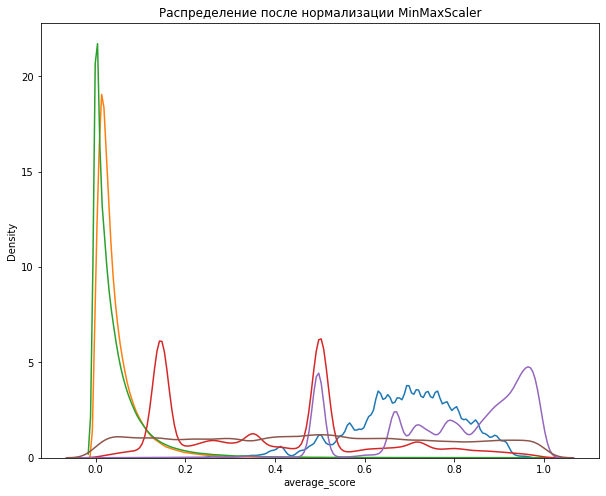

In [33]:
cols = ['average_score', 'trip_type', 'review_season', 'cnt_nights', 'positive', 'negative',
        'days_since_review', 'additional_number_of_scoring', 'total_number_of_reviews',
       'total_number_of_reviews_reviewer_has_given', 'review_total_negative_word_counts', 'review_total_positive_word_counts']

# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# копируем исходный датасет
df_mm = mm_scaler.fit_transform(hotels[cols])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels[cols] = pd.DataFrame(df_mm, columns=cols)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение после нормализации MinMaxScaler')

sns.kdeplot(hotels['average_score'], ax=ax1)
sns.kdeplot(hotels['review_total_positive_word_counts'], ax=ax1)
sns.kdeplot(hotels['review_total_negative_word_counts'], ax=ax1)
sns.kdeplot(hotels['negative'], ax=ax1)
sns.kdeplot(hotels['positive'], ax=ax1)
sns.kdeplot(hotels['days_since_review'], ax=ax1);

# **Отбор признаков**

In [34]:
# Поскольку модель может работать только с числовыми значениями, удалим признаки типа object.
colls_for_drop = ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 
                 'negative_review', 'positive_review', 'tags',  
                 'rooms', 'city', 'travelers', 'lat', 'lng']
hotels = hotels.drop(colls_for_drop, axis=1)

### **Оценка значимости признаков**
Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

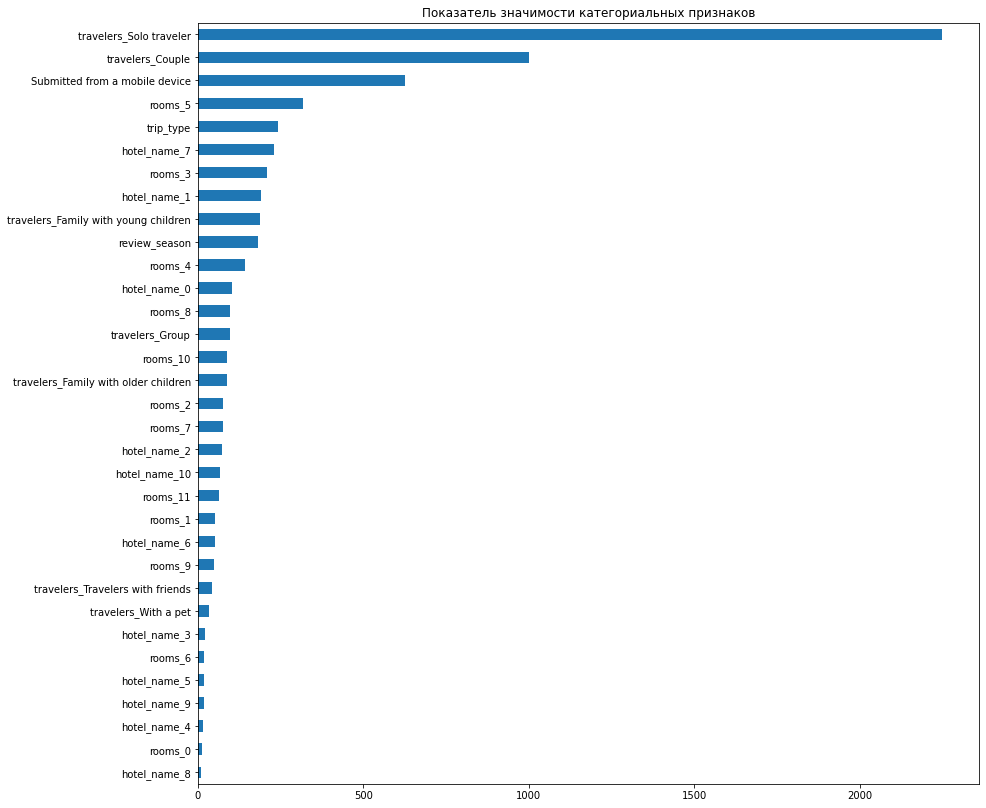

In [35]:
y=hotels['reviewer_score'].astype('int')
X = hotels

# категориальные признаки
cat_cols = ['trip_type', 'review_season',  
       'travelers_Couple', 'travelers_Group',
       'travelers_Solo traveler', 'travelers_Family with young children',
       'travelers_Family with older children', 'travelers_With a pet',
       'travelers_Travelers with friends', 'Submitted from a mobile device',
       'rooms_0', 'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4',
       'rooms_5', 'rooms_6', 'rooms_7', 'rooms_8', 'rooms_9', 'rooms_10',
       'rooms_11', 'hotel_name_0', 'hotel_name_1', 'hotel_name_2', 'hotel_name_3',
       'hotel_name_4', 'hotel_name_5', 'hotel_name_6', 'hotel_name_7',
       'hotel_name_8', 'hotel_name_9', 'hotel_name_10']

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)

fig, (ax2) = plt.subplots(ncols=1, figsize=(14, 14))
ax2.set_title('Показатель значимости категориальных признаков')
imp_cat.plot(kind = 'barh', ax = ax2);

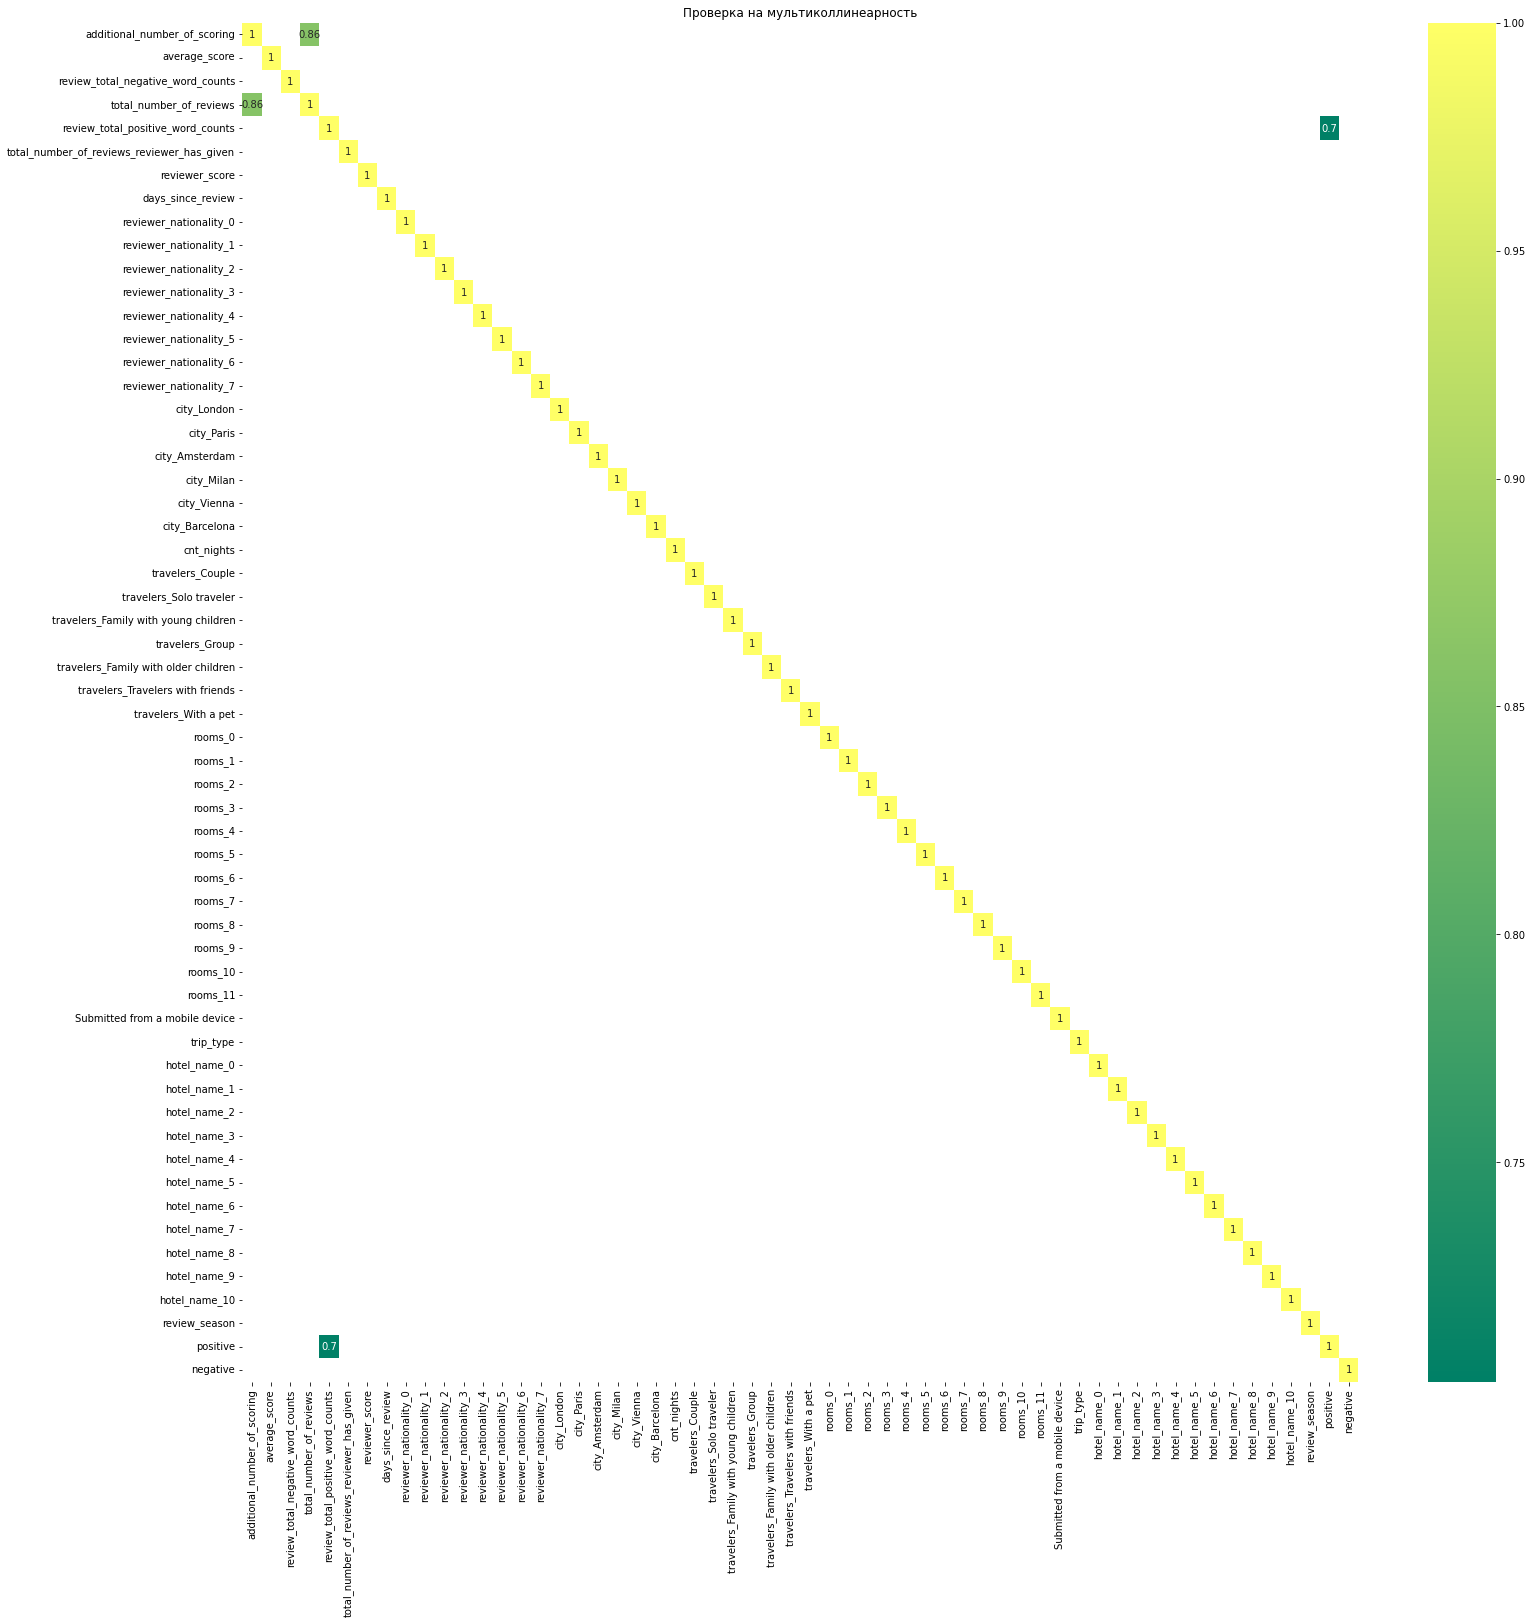

In [37]:
# Для корреляции с категориальными признаками будем использовать метод Спирмена
corr = hotels.corr(method = 'spearman')

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.7
mask_2 = np.abs(corr) <= -0.7

corr_data = corr[mask_1 | mask_2]


# проверка признака на мультиколлинеарность
fig, (ax2) = plt.subplots(ncols=1, figsize=(25, 25))
ax2.set_title('Проверка на мультиколлинеарность')
sns.heatmap(corr_data, cmap='summer', annot=True, ax=ax2);

Метод Спирмена в нашем случае показывает сильную корреляцию между двумя парами непрерывных признаков. Проверим корреляцию между ними более подходящим методом Пирсона:

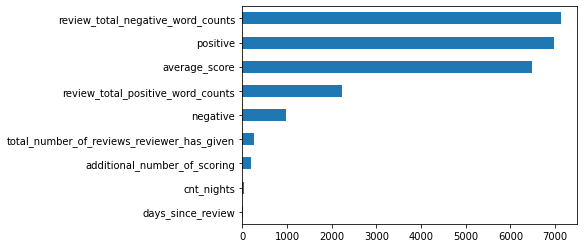

In [33]:
# непрерывные признаки
num_cols = [
    'additional_number_of_scoring', 
    'average_score', 'negative', 'positive',
    'review_total_negative_word_counts', 
    'review_total_positive_word_counts', 
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'cnt_nights'] 


from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

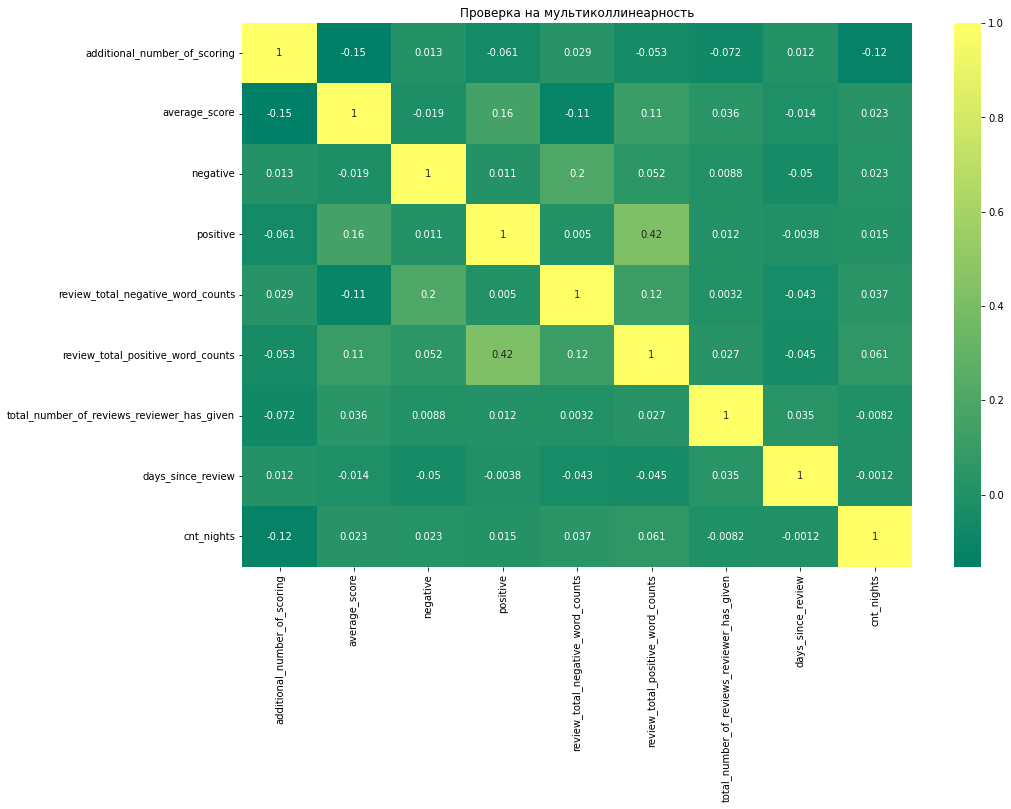

In [34]:
# проверка признака на мультиколлинеарность
fig, (ax2) = plt.subplots(ncols=1, figsize=(15, 10))
ax2.set_title('Проверка на мультиколлинеарность')
sns.heatmap(hotels[num_cols].corr(), annot=True, cmap='summer', ax=ax2);

In [39]:
cols_for_drop_2 = [
 'total_number_of_reviews_reviewer_has_given',
 'total_number_of_reviews', 
 'hotel_name_9',
 'hotel_name_7',
 'rooms_6',
 'hotel_name_8',
 'hotel_name_4',
 'hotel_name_3',
 'rooms_10',
 'days_since_review',
 'hotel_name_6',
 'hotel_name_1',
 'rooms_2',
 'hotel_name_5',
 'rooms_3',
 'hotel_name_10',
 'rooms_5',
 'rooms_1',
 'rooms_7',
 'rooms_11',
 'rooms_9',
 'hotel_name_2',
 'rooms_8',
 'rooms_4',
 'rooms_0',
 'hotel_name_0']
hotels = hotels.drop(cols_for_drop_2, axis=1)
hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 32 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   additional_number_of_scoring          386803 non-null  float64
 1   average_score                         386803 non-null  float64
 2   review_total_negative_word_counts     386803 non-null  float64
 3   review_total_positive_word_counts     386803 non-null  float64
 4   reviewer_score                        386803 non-null  float64
 5   reviewer_nationality_0                386803 non-null  int64  
 6   reviewer_nationality_1                386803 non-null  int64  
 7   reviewer_nationality_2                386803 non-null  int64  
 8   reviewer_nationality_3                386803 non-null  int64  
 9   reviewer_nationality_4                386803 non-null  int64  
 10  reviewer_nationality_5                386803 non-null  int64  
 11  

In [42]:
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis=1)
y = hotels['reviewer_score']        

In [43]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [44]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [45]:
%%time

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


CPU times: total: 4min 46s
Wall time: 5min 27s


In [48]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1257137926930847


Итак, в результате преобразований мы получили среднюю абсолютную процентную ошибку предсказанных значений от фактических (MAPE): 

0.1257137926930847, что является на данном этапе удовлетворительным показателем.